In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [2]:
# --- Webcam capture parameters ---
DEVICE_INDEX = 0
N_FRAMES = 60
TARGET_SIZE = 128       # 64, 128, 256 ... (power-of-two)
SHOW_LIVE = True        # press 'q' to stop early

cap = cv2.VideoCapture(DEVICE_INDEX)
if not cap.isOpened():
    raise RuntimeError("Could not open webcam. Try DEVICE_INDEX=1, or check OS permissions.")

frames_bgr = []
print("Capturing... (press 'q' in the live window to stop early)")
for t in range(N_FRAMES):
    ok, frame = cap.read()
    if not ok:
        print(f"Frame read failed at t={t}")
        break
    frames_bgr.append(frame)
    if SHOW_LIVE:
        cv2.imshow("Live webcam (press q to stop)", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()
print(f"Captured {len(frames_bgr)} frames.")


Capturing... (press 'q' in the live window to stop early)


QFontDatabase: Cannot find font directory /home/thomas-watts/miniconda3/envs/dvr_H/lib/python3.12/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/thomas-watts/miniconda3/envs/dvr_H/lib/python3.12/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/thomas-watts/miniconda3/envs/dvr_H/lib/python3.12/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.
QFontDatabase: Cannot find font directory /home/thomas-watts/miniconda3/envs/dvr_H/lib/python3.12/site-packages/cv2/qt/fonts.
Note that Qt no longer ships fonts. Deploy some (from https://dejavu-fonts.github.io/ for example) or switch to fontconfig.


Captured 60 frames.


In [3]:
def preprocess_frames(frames_bgr, target_size=128):
    '''BGR -> grayscale float32 in [0,1], resized to (target_size,target_size).'''
    out = []
    for fr in frames_bgr:
        gray = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (target_size, target_size), interpolation=cv2.INTER_AREA)
        out.append(gray.astype(np.float32) / 255.0)
    return np.stack(out, axis=0)

G = preprocess_frames(frames_bgr, target_size=TARGET_SIZE)
T, H, W = G.shape
print("G:", G.shape, "range:", (float(G.min()), float(G.max())))


G: (60, 128, 128) range: (0.0, 0.6274510025978088)


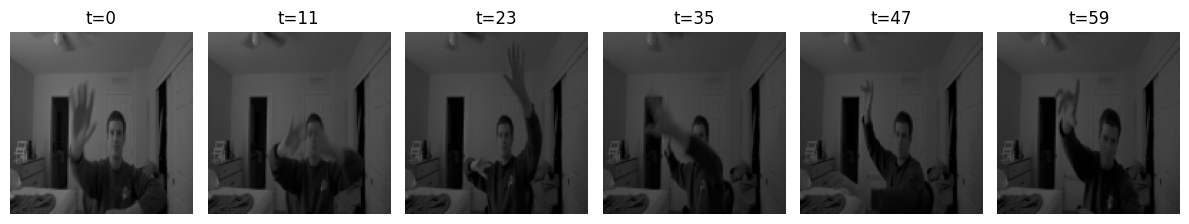

In [4]:
idxs = np.linspace(0, T-1, num=min(6, T), dtype=int)
plt.figure(figsize=(12, 2.5))
for k, i in enumerate(idxs):
    ax = plt.subplot(1, len(idxs), k+1)
    ax.imshow(G[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"t={i}")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [5]:
# -----------------------------
# Tensorization: image <-> (2,)*n tensor with interleaved (rowbit, colbit, ...)
# -----------------------------
def _check_power_of_two(n: int) -> int:
    if n <= 0 or (n & (n-1)) != 0:
        raise ValueError(f"Expected power-of-two, got {n}")
    return int(np.log2(n))

def image_to_qubit_tensor(img2d: np.ndarray):
    '''
    Map a (2^k x 2^k) image to an order-n tensor with n=2k physical dims of size 2.
    Axes interleave row/col bits: (r0,c0,r1,c1,...).
    Works with float images (can be negative too, e.g. deltas).
    '''
    H, W = img2d.shape
    kH = _check_power_of_two(H)
    kW = _check_power_of_two(W)
    if kH != kW:
        raise ValueError("Assumes square images (2^k x 2^k).")
    k = kH
    n = 2 * k

    rr = np.arange(H, dtype=np.uint32)[:, None]
    cc = np.arange(W, dtype=np.uint32)[None, :]

    bits = []
    for b in range(k):
        bits.append((rr >> b) & 1)
        bits.append((cc >> b) & 1)

    bits = [np.broadcast_to(x, (H, W)) for x in bits]
    multi = np.stack(bits, axis=-1).astype(np.int64)  # (H,W,n)

    Tn = np.zeros((2,) * n, dtype=img2d.dtype)
    idx = tuple(multi[..., j] for j in range(n))
    Tn[idx] = img2d
    return Tn

def qubit_tensor_to_image(Tn: np.ndarray):
    '''
    Inverse mapping. Input tensor shape (2,)*n with even n=2k.
    Output image shape (2^k,2^k).
    '''
    n = Tn.ndim
    if n % 2 != 0:
        raise ValueError("Expected even order tensor (n=2k).")
    k = n // 2
    H = W = 2 ** k

    rr = np.arange(H, dtype=np.uint32)[:, None]
    cc = np.arange(W, dtype=np.uint32)[None, :]

    bits = []
    for b in range(k):
        bits.append(((rr >> b) & 1).astype(np.int64))
        bits.append(((cc >> b) & 1).astype(np.int64))

    bits = [np.broadcast_to(x, (H, W)) for x in bits]
    multi = np.stack(bits, axis=-1)
    idx = tuple(multi[..., j] for j in range(n))
    return Tn[idx]

# -----------------------------
# TT-SVD with cutoff-only truncation
# -----------------------------
def _choose_rank_by_cutoff(S: np.ndarray, cutoff_rel: float):
    '''
    Smallest r such that discarded energy <= cutoff_rel * total energy, where energy = sum S^2.
    cutoff_rel <= 0 disables truncation (keeps full rank).
    '''
    if cutoff_rel <= 0:
        return len(S)
    s2 = S**2
    total = float(np.sum(s2))
    if total <= 0:
        return 1
    cumsum = np.cumsum(s2)
    discarded = total - cumsum
    ok = np.where(discarded / total <= cutoff_rel)[0]
    if len(ok) == 0:
        return len(S)
    return int(ok[0] + 1)

def tt_svd_qubits_cutoff(Tn: np.ndarray, cutoff_rel: float):
    '''
    TT-SVD for tensor dims (2,2,...,2). Returns (cores, ranks).
    cores[i] shape (r_i, 2, r_{i+1}).
    '''
    n = Tn.ndim
    cores = []
    r = 1
    X = Tn.reshape((2,) * n)
    ranks = [1]
    for i in range(n - 1):
        X = X.reshape((r * 2, -1))
        U, S, Vt = np.linalg.svd(X, full_matrices=False)
        keep = _choose_rank_by_cutoff(S, cutoff_rel=cutoff_rel)
        U = U[:, :keep]
        S = S[:keep]
        Vt = Vt[:keep, :]
        cores.append(U.reshape((r, 2, keep)))
        X = (S[:, None] * Vt)
        r = keep
        ranks.append(r)
    cores.append(X.reshape((r, 2, 1)))
    ranks.append(1)
    return cores, ranks

def tt_reconstruct_qubits(cores):
    X = np.squeeze(cores[0], 0)  # (2, r1)
    for i in range(1, len(cores)):
        X = np.tensordot(X, cores[i], axes=([X.ndim - 1], [0]))
    return np.squeeze(X, -1)

def mps_from_image(img2d: np.ndarray, cutoff_rel: float):
    Tn = image_to_qubit_tensor(img2d)
    return tt_svd_qubits_cutoff(Tn, cutoff_rel=cutoff_rel)

def image_from_mps(cores):
    return qubit_tensor_to_image(tt_reconstruct_qubits(cores))


In [6]:
# -----------------------------
# Two cutoffs:
#   - tight for frames G_t
#   - looser for deltas Δ_t
# -----------------------------
CUTOFF_G = 1e-6   # small => high-fidelity G_t (try 1e-7 .. 1e-5)
CUTOFF_D = 1e-3   # larger => stronger compression for deltas (try 1e-4 .. 1e-2)

# 1) Compress frames with cutoff_G
G_hat = np.zeros_like(G, dtype=np.float32)
ranks_G = []
cores_G = []

for t in range(T):
    cores, ranks = mps_from_image(G[t], cutoff_rel=CUTOFF_G)
    cores_G.append(cores)
    ranks_G.append(ranks)
    G_hat[t] = image_from_mps(cores).astype(np.float32)

# 2) Build true deltas from original frames (not from G_hat)
Delta = np.zeros_like(G, dtype=np.float32)
Delta[1:] = G[1:] - G[:-1]

# 3) Compress deltas with cutoff_D
Delta_hat = np.zeros_like(Delta, dtype=np.float32)
ranks_D = []
cores_D = []

for t in range(T):
    if t == 0:
        Delta_hat[t] = 0.0
        ranks_D.append([1]*(2*_check_power_of_two(H)+1))  # placeholder
        cores_D.append(None)
        continue
    cores, ranks = mps_from_image(Delta[t], cutoff_rel=CUTOFF_D)
    cores_D.append(cores)
    ranks_D.append(ranks)
    Delta_hat[t] = image_from_mps(cores).astype(np.float32)

# 4) Reconstruct via G0 + cumsum(Delta_hat)
G_tilde = np.zeros_like(G, dtype=np.float32)
G_tilde[0] = G_hat[0]
G_tilde[1:] = G_hat[0] + np.cumsum(Delta_hat[1:], axis=0)

# Metrics
def mse(a,b): return np.mean((a-b)**2, axis=(1,2))
mse_Ghat = mse(G_hat, G)
mse_Gtilde = mse(G_tilde, G)
psnr_Ghat = 10*np.log10(1.0/np.maximum(mse_Ghat, 1e-12))
psnr_Gtilde = 10*np.log10(1.0/np.maximum(mse_Gtilde, 1e-12))

maxbond_G = np.array([max(r) for r in ranks_G], dtype=int)
maxbond_D = np.array([max(r) if isinstance(r, list) else 0 for r in ranks_D], dtype=int)

print("CUTOFF_G =", CUTOFF_G, "| derived maxbond_G min/mean/max =", int(maxbond_G.min()), float(maxbond_G.mean()), int(maxbond_G.max()))
print("CUTOFF_D =", CUTOFF_D, "| derived maxbond_D min/mean/max =", int(maxbond_D[1:].min()), float(maxbond_D[1:].mean()), int(maxbond_D[1:].max()))
print("Frame recon (G_hat vs G)  PSNR mean =", float(psnr_Ghat.mean()))
print("Delta-sum recon (G_tilde vs G) PSNR mean =", float(psnr_Gtilde.mean()))


CUTOFF_G = 1e-06 | derived maxbond_G min/mean/max = 98 102.36666666666666 108
CUTOFF_D = 0.001 | derived maxbond_D min/mean/max = 44 64.88135593220339 76
Frame recon (G_hat vs G)  PSNR mean = 70.41960906982422
Delta-sum recon (G_tilde vs G) PSNR mean = 44.95173263549805


In [7]:
# -----------------------------
# Inspect MPS cores + storage (real-valued entries)
# -----------------------------
# Choose which frame to inspect (0..T-1)
t_inspect = min(1, T-1)  # change me

def summarize_cores(cores):
    shapes = [tuple(c.shape) for c in cores]
    # bond dims r0..rL from shapes (r_i, 2, r_{i+1})
    r = [shapes[0][0]] + [s[2] for s in shapes]
    return shapes, r

def cores_storage_kb(cores, bytes_per_entry=4):
    # total number of scalar entries across all cores
    total_entries = int(sum(np.prod(c.shape) for c in cores))
    total_bytes = total_entries * int(bytes_per_entry)
    return total_entries, total_bytes / 1024.0

print("=== Frame MPS (G) ===")
cores = cores_G[t_inspect]
shapes, r = summarize_cores(cores)
print("t =", t_inspect)
print("bond dims r0..rL =", r, " | max bond =", max(r))
print("core shapes:")
for j, s in enumerate(shapes):
    print(f"  core {j:02d}: {s}")

e32, kb32 = cores_storage_kb(cores, bytes_per_entry=4)   # float32
e64, kb64 = cores_storage_kb(cores, bytes_per_entry=8)   # float64
print(f"storage (real float32): {kb32:.2f} kB  [{e32:,} entries]")
print(f"storage (real float64): {kb64:.2f} kB  [{e64:,} entries]")

print("\n=== Delta MPS (Δ) ===")
if t_inspect == 0 or cores_D[t_inspect] is None:
    print("Δ[0] is zero by construction (no cores).")
else:
    dcores = cores_D[t_inspect]
    dshapes, dr = summarize_cores(dcores)
    print("t =", t_inspect)
    print("bond dims r0..rL =", dr, " | max bond =", max(dr))
    print("core shapes:")
    for j, s in enumerate(dshapes):
        print(f"  core {j:02d}: {s}")
    de32, dkb32 = cores_storage_kb(dcores, bytes_per_entry=4)
    de64, dkb64 = cores_storage_kb(dcores, bytes_per_entry=8)
    print(f"storage (real float32): {dkb32:.2f} kB  [{de32:,} entries]")
    print(f"storage (real float64): {dkb64:.2f} kB  [{de64:,} entries]")

# Optional: total storage over all frames (G cores + delta cores)
bytes_per_entry = 4  # set 4 for float32 or 8 for float64

total_entries_G = 0
total_entries_D = 0
for t in range(T):
    total_entries_G += int(sum(np.prod(c.shape) for c in cores_G[t]))
for t in range(1, T):
    if cores_D[t] is not None:
        total_entries_D += int(sum(np.prod(c.shape) for c in cores_D[t]))

total_kb_G = (total_entries_G * bytes_per_entry) / 1024.0
total_kb_D = (total_entries_D * bytes_per_entry) / 1024.0
print("\n=== Total stream storage (all frames) ===")
print(f"G stream total (all t)      : {total_kb_G:.2f} kB  [{total_entries_G:,} entries]  using {bytes_per_entry}-byte reals")
print(f"Delta stream total (t>=1)   : {total_kb_D:.2f} kB  [{total_entries_D:,} entries]  using {bytes_per_entry}-byte reals")
print(f"Combined (G + Δ)            : {total_kb_G + total_kb_D:.2f} kB")
print("If you transmit only G0 once + all Δ: approximate transmitted storage is")
print(f"  G0 only + all Δ           : {((int(sum(np.prod(c.shape) for c in cores_G[0])) + total_entries_D) * bytes_per_entry)/1024.0:.2f} kB")


=== Frame MPS (G) ===
t = 1
bond dims r0..rL = [1, 2, 4, 8, 16, 32, 64, 100, 61, 32, 16, 8, 4, 2, 1]  | max bond = 100
core shapes:
  core 00: (1, 2, 2)
  core 01: (2, 2, 4)
  core 02: (4, 2, 8)
  core 03: (8, 2, 16)
  core 04: (16, 2, 32)
  core 05: (32, 2, 64)
  core 06: (64, 2, 100)
  core 07: (100, 2, 61)
  core 08: (61, 2, 32)
  core 09: (32, 2, 16)
  core 10: (16, 2, 8)
  core 11: (8, 2, 4)
  core 12: (4, 2, 2)
  core 13: (2, 2, 1)
storage (real float32): 139.56 kB  [35,728 entries]
storage (real float64): 279.12 kB  [35,728 entries]

=== Delta MPS (Δ) ===
t = 1
bond dims r0..rL = [1, 2, 4, 8, 16, 30, 52, 64, 43, 23, 11, 6, 4, 2, 1]  | max bond = 64
core shapes:
  core 00: (1, 2, 2)
  core 01: (2, 2, 4)
  core 02: (4, 2, 8)
  core 03: (8, 2, 16)
  core 04: (16, 2, 30)
  core 05: (30, 2, 52)
  core 06: (52, 2, 64)
  core 07: (64, 2, 43)
  core 08: (43, 2, 23)
  core 09: (23, 2, 11)
  core 10: (11, 2, 6)
  core 11: (6, 2, 4)
  core 12: (4, 2, 2)
  core 13: (2, 2, 1)
storage (real f

In [11]:
# -----------------------------
# Sanity check: all MPS cores are real-valued
# -----------------------------
# Assumes you have:
#   cores_G : list of list-of-cores for frames G_t
#   cores_D : list of list-of-cores for deltas Δ_t (may contain None at t=0)

import numpy as np

def is_real_array(a: np.ndarray, atol: float = 0.0) -> bool:
    """
    Returns True if array is real dtype OR (if complex dtype) its imaginary part is ~0.
    """
    if np.isrealobj(a):
        return True
    return np.max(np.abs(np.imag(a))) <= atol

def check_cores_real(cores_stream, name="cores", atol=0.0, allow_none=True):
    bad = []
    for t, cores in enumerate(cores_stream):
        if cores is None:
            if allow_none:
                continue
            bad.append((t, None, "cores is None"))
            continue
        for j, c in enumerate(cores):
            if c is None:
                if allow_none:
                    continue
                bad.append((t, j, "core is None"))
                continue
            if not is_real_array(c, atol=atol):
                imax = float(np.max(np.abs(np.imag(c)))) if not np.isrealobj(c) else 0.0
                bad.append((t, j, f"complex (max|imag|={imax:g})", str(c.dtype), tuple(c.shape)))
    if bad:
        print(f"[FAIL] {name}: Found {len(bad)} non-real core(s). Showing up to 20:")
        for item in bad[:20]:
            print("  ", item)
        return False
    print(f"[OK] {name}: All cores are real within atol={atol}.")
    return True

# Run checks
ok_G = check_cores_real(cores_G, name="G cores", atol=0.0, allow_none=False)
ok_D = check_cores_real(cores_D, name="Δ cores", atol=0.0, allow_none=True)

# Optional hard assert
assert ok_G and ok_D, "Some cores are not real-valued (or have nonzero imaginary parts)."


[OK] G cores: All cores are real within atol=0.0.
[OK] Δ cores: All cores are real within atol=0.0.


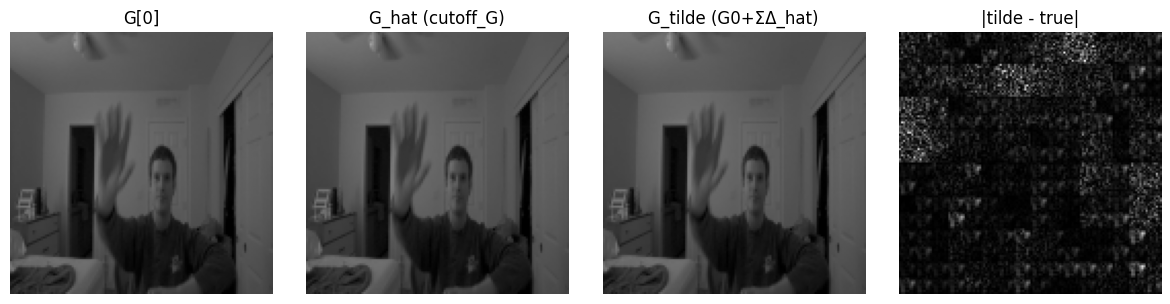

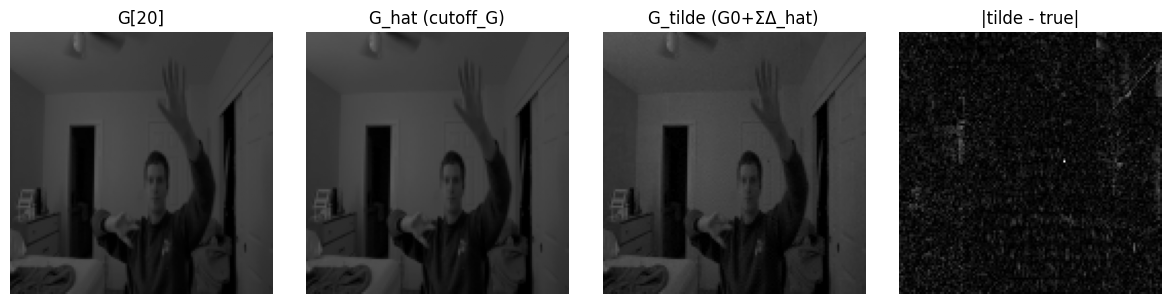

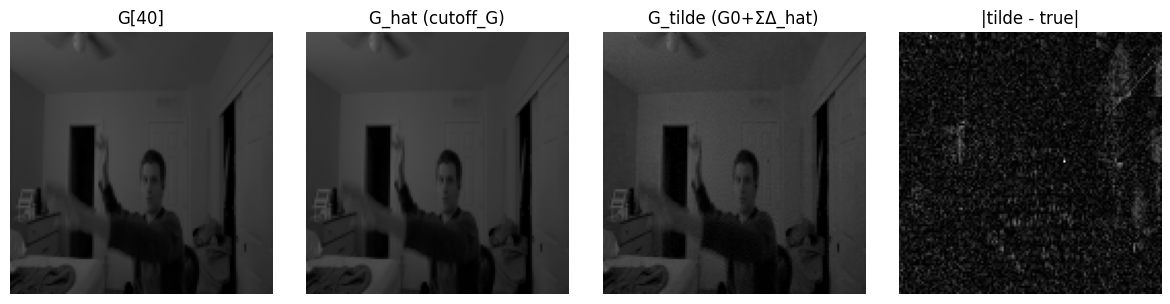

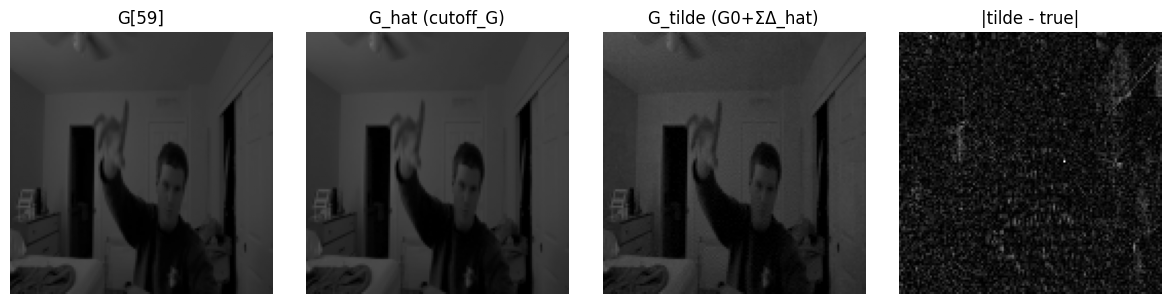

In [8]:
# Visualize a few frames: original, G_hat (tight), G_tilde (from compressed deltas)
def show_compare(t):
    plt.figure(figsize=(12,3))
    ax1 = plt.subplot(1,4,1)
    ax1.imshow(G[t], cmap="gray", vmin=0, vmax=1); ax1.set_title(f"G[{t}]"); ax1.axis("off")
    ax2 = plt.subplot(1,4,2)
    ax2.imshow(np.clip(G_hat[t],0,1), cmap="gray", vmin=0, vmax=1); ax2.set_title("G_hat (cutoff_G)"); ax2.axis("off")
    ax3 = plt.subplot(1,4,3)
    ax3.imshow(np.clip(G_tilde[t],0,1), cmap="gray", vmin=0, vmax=1); ax3.set_title("G_tilde (G0+ΣΔ_hat)"); ax3.axis("off")
    ax4 = plt.subplot(1,4,4)
    ax4.imshow(np.abs(G_tilde[t]-G[t]), cmap="gray"); ax4.set_title("|tilde - true|"); ax4.axis("off")
    plt.tight_layout(); plt.show()

for t in [0, T//3, 2*T//3, T-1]:
    if 0 <= t < T:
        show_compare(t)


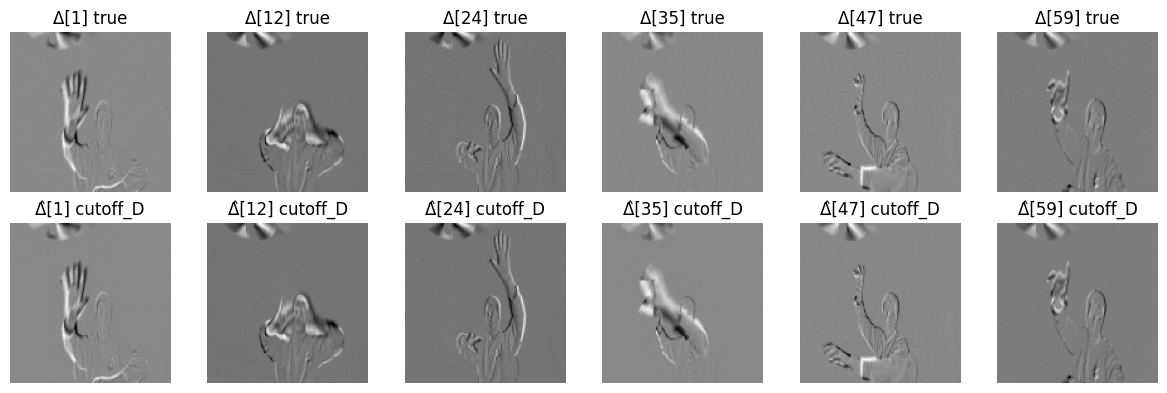

In [9]:
# Show a few delta frames (true vs compressed)
idxs = np.linspace(1, T-1, num=min(6, max(1, T-1)), dtype=int)
plt.figure(figsize=(12, 4))
for k, i in enumerate(idxs):
    ax = plt.subplot(2, len(idxs), k+1)
    ax.imshow(Delta[i], cmap="gray")
    ax.set_title(f"Δ[{i}] true")
    ax.axis("off")
for k, i in enumerate(idxs):
    ax = plt.subplot(2, len(idxs), len(idxs)+k+1)
    ax.imshow(Delta_hat[i], cmap="gray")
    ax.set_title(f"Δ̂[{i}] cutoff_D")
    ax.axis("off")
plt.tight_layout()
plt.show()


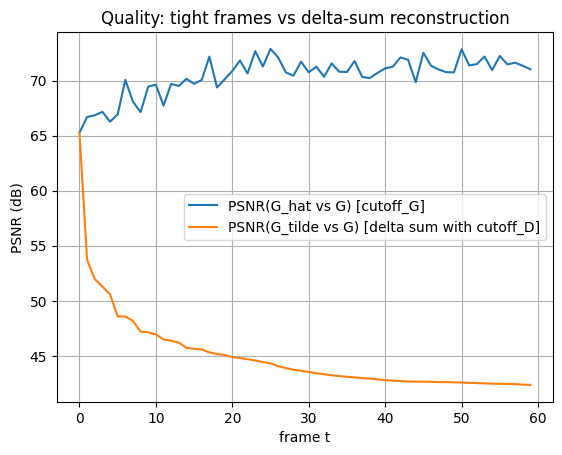

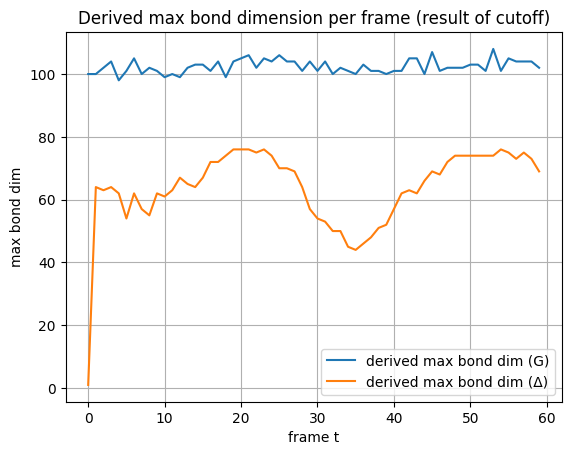

In [10]:
plt.figure()
plt.plot(psnr_Ghat, label="PSNR(G_hat vs G) [cutoff_G]")
plt.plot(psnr_Gtilde, label="PSNR(G_tilde vs G) [delta sum with cutoff_D]")
plt.xlabel("frame t"); plt.ylabel("PSNR (dB)")
plt.title("Quality: tight frames vs delta-sum reconstruction")
plt.grid(True); plt.legend()
plt.show()

plt.figure()
plt.plot(maxbond_G, label="derived max bond dim (G)")
plt.plot(maxbond_D, label="derived max bond dim (Δ)")
plt.xlabel("frame t"); plt.ylabel("max bond dim")
plt.title("Derived max bond dimension per frame (result of cutoff)")
plt.grid(True); plt.legend()
plt.show()



## Knobs to try

- Keep `CUTOFF_G` **small** (e.g., `1e-7` to `1e-5`) so \(\hat G_t\) is close to the original.
- Sweep `CUTOFF_D` **larger** (e.g., `1e-4` to `1e-2`) to see how hard you can compress motion updates.

If you want the “transmitted stream” idea:
- send \(\hat G_0\) once (high fidelity),
- then send only the compressed \(\hat\Delta_t\) updates.
